# Data Exploration
- No missing data in original data. Lots of missing data in IMDB set
- There are "rare" movies at the tail
    - 17% of movies have only 1 rating
    - 43% of movies have 5 or less ratings 
- Merge loses 17410 movies that aren't in the IMDB dataset


In [1]:
import pandas as pd
import os
import numpy as np
from scipy.sparse import csc_matrix
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
links = pd.read_csv('data/ml-25m/links.csv')
movies = pd.read_csv('data/ml-25m/movies.csv')
#ratings = pd.read_csv('data/ml-25m/ratings.csv')

In [5]:
# distribution of number of ratings per movie. Many don't have many ratings. 
x = ratings.groupby('movieId').count()
x.userId.describe()

count    59047.000000
mean       423.393144
std       2477.885821
min          1.000000
25%          2.000000
50%          6.000000
75%         36.000000
max      81491.000000
Name: userId, dtype: float64

In [4]:
len(x[x.userId == 1]) / len(x)

0.174403441326401

In [5]:
len(x[x.userId <= 2]) / len(x)

0.3036733449624875

In [6]:
len(x[x.userId <= 5]) / len(x)

0.48842447541788747

### Merge all Data (including IMDB dataset)
Searched kaggle for a larger set and did not find one that also had IMDB IDs

In [3]:
# IMDB dataset
imdb_movies = pd.read_csv('data/imdb/IMDb movies.csv')

# standardize IMDB IDs
imdb_movies['imdbId'] = imdb_movies.imdb_title_id.str.split('tt').str[1]
imdb_movies.imdbId = pd.to_numeric(imdb_movies.imdbId)

In [4]:
# merge all dataset together 
num_movies = len(movies)
# links (has imdb rating) + movies
df = pd.merge(links, movies, on = 'movieId')
# merge with imdb data
df = pd.merge(df, imdb_movies, on = 'imdbId')
# titles are different in movielens vs imdb because imdb in the original language whereas movielens all english translated
df = df.rename(columns = {'title_x':'title_eng', 'title_y':'title_orig'})

new_num_movies = len(df)

In [5]:
# limit to relevant columns
df = df[['movieId', 'title_eng', 'year', 'genre', 'genres', 'director', 'actors', 'country']]

## Missing Data Post Merge

In [7]:
# number of movies lost in merge
num_movies - new_num_movies

17410

In [8]:
new_num_movies

45013

In [9]:
df.isnull().sum()

movieId       0
title_eng     0
year          0
genre         0
genres        0
director     13
actors       20
country      10
dtype: int64

## Exploratory Visualizations
Using full dataset, not subsampled

In [226]:
def barplot(df, x, h, title, ylabel):

    fig, ax = plt.subplots(figsize = (8,6))
    sns.barplot(df[x], df[h])
    plt.xticks(rotation='vertical', size = 12)
    plt.yticks(size = 12)

    ax.set_xlabel('')
    ax.set_ylabel(ylabel, size = 12)
    ax.set_title(title, size = 14)

In [6]:
def cat_list_expand(df, var):
    
    # expand lists such that one entry per row 
    expanded = df[var].to_frame()
    expanded = pd.DataFrame({
        var:np.repeat(expanded[var].values, expanded[var].str.len())}
    ).assign(**{var:np.concatenate(expanded[var].values)})[expanded.columns]

    return expanded

__Frequency of Genres__   
Individual genres

In [235]:
# expand genre lists such that one row per entry
genres_exapnded = cat_list_expand(df, 'genres_all')

# plot
genre_counts = genres_expanded.groupby('genres_all').genres_all.count().to_frame()
genre_counts.columns = ['cnt']
genre_counts = genre_counts.sort_values(['cnt'])
genre_counts['genres'] = genre_counts.index

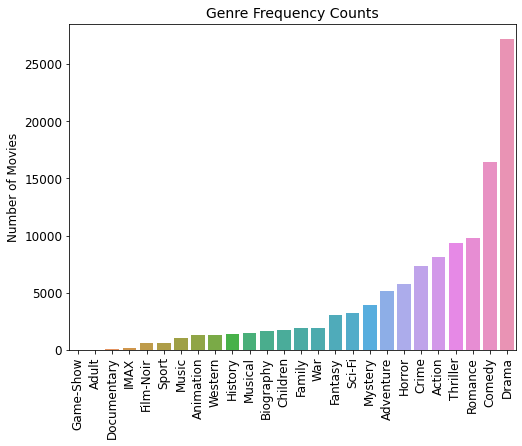

In [236]:
barplot(genre_counts, 'genres', 'cnt', 'Genre Frequency Counts', 'Number of Movies')

__Most Popular Genre Combinations__

In [213]:
# convert list to tuple so hashable
df.genres_all = df.genres_all.apply(tuple)

# count by unique genre combination (verified lists internally sorted the same)
genre_combos = df.groupby('genres_all').movieId.count().to_frame()
genre_combos.columns = ['cnt']

# take top 10 most popular
genre_combos = genre_combos.sort_values('cnt').tail(10)

# clean index string 
genre_combos.index = genre_combos.index.map(str)
genre_combos['lst'] = genre_combos.index
genre_combos.lst = genre_combos.lst.str.replace('(', '').str.replace(')', '').str.replace(',', '')

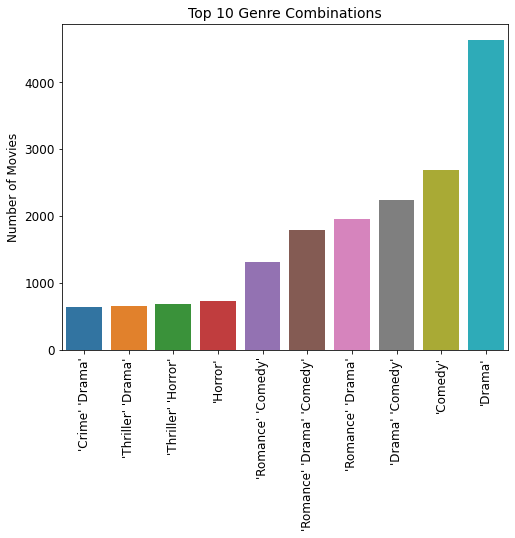

In [228]:
barplot(genre_combos, 'lst', 'cnt', 'Top 10 Genre Combinations', 'Number of Movies')

__Frequency of Movies by Year__

In [136]:
movies_yr = df.groupby('year').movieId.count().to_frame()

Text(0.5, 1.0, 'Release Year Frequency Counts')

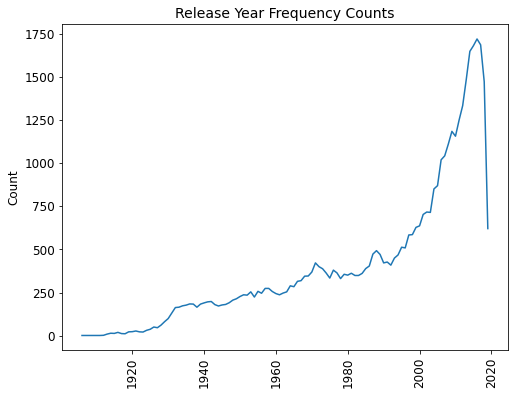

In [142]:
fig, ax = plt.subplots(figsize = (8,6))
sns.lineplot(movies_yr.index, movies_yr.movieId)
plt.xticks(rotation='vertical', size = 12)
plt.yticks(size = 12)

ax.set_xlabel('')
ax.set_ylabel('Count', size = 12)
ax.set_title('Release Year Frequency Counts', size = 14)

__Frequency of Year of Review__: Do we have older reviews that should be downweighted?

__Distribution of Number of Ratings__: How much of a long tail do we have?

__Most Popular Actors__

In [7]:
# split string variable into list 
df['actor_lst'] = df.actors.str.split(', ')
# when missing, replace to list rather than nan 
df.actor_lst = df.actor_lst.apply(lambda d: d if isinstance(d, list) else [])

In [8]:
# expand actor list
actors_expanded = cat_list_expand(df, 'actor_lst')

# count number of movies for each actor and prep for plotting 
actors_expanded = actors_expanded.groupby('actor_lst').actor_lst.count().to_frame()
actors_expanded.columns = ['cnt']
actors_expanded = actors_expanded.sort_values(['cnt'])
actors_expanded['actors'] = actors_expanded.index

In [9]:
# percent of actors that are only in 1, <= 2 movies
# do not need to include these in analysis because not useful for identifying similar movies
     # even actors in only 2 movies. If watched one of the movies, could recommend the other one, but that is it. 
print(len(actors_expanded[actors_expanded.cnt == 1]) / len(actors_expanded))
print(len(actors_expanded[actors_expanded.cnt <= 2]) / len(actors_expanded))

actors_exclude = actors_expanded[actors_expanded.cnt <= 2].actors.unique()

0.6667830620373791
0.7996686792238323


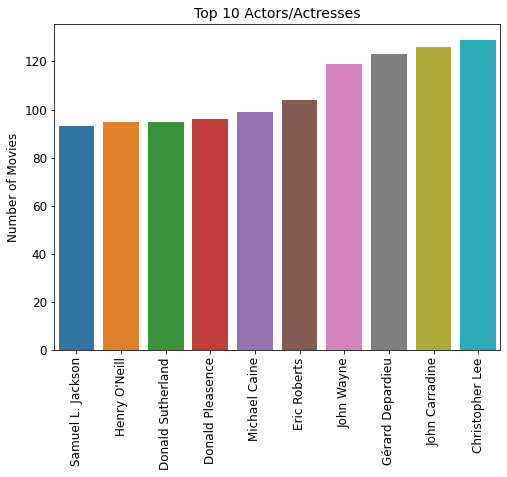

In [233]:
barplot(actors_expanded.tail(10), 'actors', 'cnt', 'Top 10 Actors/Actresses', 'Number of Movies')

__Most Popular Directors__

In [10]:
# split string variable into list
df['director_lst'] = df.director.str.split(', ')
# when missing, replace to list rather than nan 
df.director_lst = df.director_lst.apply(lambda d: d if isinstance(d, list) else [])

In [11]:
# expand actor list
directors_expanded = cat_list_expand(df, 'director_lst')

# count number of movies for each actor and prep for plotting 
directors_expanded = directors_expanded.groupby('director_lst').director_lst.count().to_frame()
directors_expanded.columns = ['cnt']
directors_expanded = directors_expanded.sort_values(['cnt'])
directors_expanded['director'] = directors_expanded.index

In [12]:
# percent of actors that are only in 1, <= 2 movies
# do not need to include these in analysis because not useful for identifying similar movies
     # even actors in only 2 movies. If watched one of the movies, could recommend the other one, but that is it. 
print(len(directors_expanded[directors_expanded.cnt == 1]) / len(directors_expanded))
print(len(directors_expanded[directors_expanded.cnt <= 2]) / len(directors_expanded))

directors_exclude = directors_expanded[directors_expanded.cnt <= 2].director.unique()

0.5920960909432141
0.7578422435519331


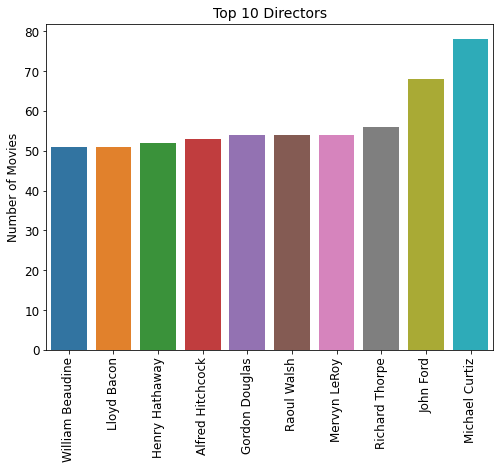

In [364]:
barplot(directors_expanded.tail(10), 'director', 'cnt', 'Top 10 Directors', 'Number of Movies')

## Create Dummy Variables  
- Genre
    - IMDB and MovieLens sometimes have a different genre list for the same movie. Take the union of both lists to get the max number of genres/information.  
    - MovieLens: genres
    - IMDB: genre
- Actors
- Directors
    - Exclude actors and directors that have only been in 1 movie in dataset. Not relevant for finding similar movies
    - May need to rerun this piece once subset data as there may be more in only 1 movie 


__Union Genre Lists__

In [335]:
# movielens missing value
df.genres = np.where(df.genres == '(no genres listed)', np.nan, df.genres)

# convert into sets and take union 
df.genre = df.genre.str.split(', ')
df.genres = df.genres.str.split('|')

# when missing in movielens, replace to list rather than nan 
df.genres = df.genres.apply(lambda d: d if isinstance(d, list) else [])

df.genre = df.genre.apply(set)
df.genres = df.genres.apply(set)

df['genres_all'] = df.apply(lambda x: x['genre'].union(x['genres']), axis=1)
df.genres_all = df.genres_all.apply(list)

__Exclude Rare Actors, Directors: Not Useful for Recommendations__    
And including all results in memory errors

In [13]:
# exclude if only in 1 movie (in dataset)
df.actor_lst = df.actor_lst.map(set) - set(actors_exclude)
df.director_lst = df.director_lst.map(set) - set(directors_exclude)

# map back to list
df.actor_lst = df.actor_lst.map(list)
df.director_lst = df.director_lst.map(list)

__Create Dummies__    
Taking out actors and directors with fewer than 3 movies, but still memory issues.  

In [ ]:
# clear up memory 
del imdb_movies
del actors_expanded
del directors_expanded 
del movies
del links

In [337]:
#for var in ['genres_all', 'actor_lst', 'director_lst']:

for var in ['actor_lst']:

    prefix = var.split('_')[0]

    # dummy variables
    dummies = pd.get_dummies(df[var].apply(pd.Series).stack(), prefix = prefix).sum(level = 0)

    # merge back in
    df = pd.merge(df, dummies, left_index = True, right_index = True)

AttributeError: 'bool' object has no attribute 'any'

## Create User-Ratings Utility Matrix

In [24]:
ratings = ratings.sort_values(['userId', 'movieId'])
users_c = CategoricalDtype(sorted(ratings.userId.unique()), ordered=True)
movies_c = CategoricalDtype(sorted(ratings.movieId.unique()), ordered=True)

row = ratings.userId.astype(users_c).cat.codes
col = ratings.movieId.astype(movies_c).cat.codes
utility_matrix = csc_matrix((ratings.rating, (row, col)), 
                           shape=(users_c.categories.size, movies_c.categories.size))

utility_matrix.shape # row = users, columns = movies

In [72]:
# check: look at userId = 1, what movies have non-zero values in the matrix?
print(utility_matrix[0,:].nonzero())

# find indexes of movie IDs 
movies_lst = sorted(ratings.movieId.unique())
movies_lst.index(296) # movieId 296 = index 292. First nonzero element in sparse matrix. 

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0]), array([ 292,  302,  303,  654,  878, 1061, 1147, 1186, 1205, 1217, 1227,
       1591, 1922, 1923, 1979, 2071, 2260, 2482, 2541, 2600, 2751, 3352,
       3470, 3845, 4040, 4203, 4220, 4317, 4598, 4867, 5041, 5161, 5573,
       5655, 5766, 5800, 5840, 5904, 6252, 6258, 6416, 6588, 6829, 7084,
       7109, 7193, 7198, 7202, 7236, 7240, 7476, 7547, 7548, 7549, 7550,
       7593, 7653, 7720, 7734, 7775, 7972, 8015, 8072, 8158, 8258, 9120,
       9143, 9304, 9645, 9778]))


292

In [73]:
ratings[ratings.userId == 1]

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
65,1,27193,3.0,1147879774
66,1,27266,4.5,1147879365
67,1,27721,3.0,1147869115
68,1,31956,3.5,1147877610
